# Simple MNIST Model

In this notebook we will create a simple model to predicts what letter is written in a 28x28 image based on the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).  This is done via a two fully connected layer Neural Network on a flattened version of the image.

## Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

## Download Mnist Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Explore Data

In [3]:
def show_image(image):
    plt.imshow(image.reshape((28, 28)), cmap='gray')

Label: [0 0 0 0 1 0 0 0 0 0]
Argmax: 4


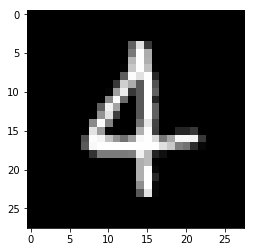

In [4]:
index = random.randint(0, len(mnist.train.images))

image = mnist.train.images[index]
label = mnist.train.labels[index]

print('Label: {}\nArgmax: {}'.format(label.astype(int), np.argmax(label)))

show_image(image)

## Define Model

In [5]:
# Reset graph
tf.reset_default_graph()
# Set reuse to AUTO_REUSE, this allows you to run tf.get_variable() more than once.
tf.get_variable_scope()._reuse = tf.AUTO_REUSE

#### Hyperparameters

In [6]:
# Learning rate
learning_rate = 0.001
# Batch Size
batch_size = 128
# Epochs
epochs = 2000

#### Model Inputs

In [7]:
# Input Images
features = tf.placeholder(tf.float32, [None, 28, 28, 1], name='features')

# True Values
labels = tf.placeholder(tf.float32, [None, 10], name='labels')

# Keep Probability
keep_prob = tf.placeholder(tf.float32)

#### Layer 1: Convolution/Max Pool

In [8]:
# Shape = 28x28x1

# Weights
W_1 = tf.get_variable('W_1', shape=[5, 5, 1, 32], initializer=tf.truncated_normal_initializer)
# Bias
b_1 = tf.get_variable('b_1', shape=[32], initializer=tf.zeros_initializer)
# Create Layer
layer_1 = tf.nn.conv2d(features, W_1, strides=[1, 1, 1, 1], padding='SAME') + b_1
# Activate
layer_1 = tf.nn.relu(layer_1)

# Shape = 28x28x32

# Max Pool
layer_1 = tf.nn.max_pool(layer_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Shape = 14x14x32

#### Layer 2: Convolution/Max Pool

In [9]:
# Shape = 14x14x32

# Weights
W_2 = tf.get_variable('W_2', shape=[5, 5, 32, 64], initializer=tf.truncated_normal_initializer)
# Bias
b_2 = tf.get_variable('b_2', shape=[64], initializer=tf.zeros_initializer)
# Create Layer
layer_2 = tf.nn.conv2d(layer_1, W_2, strides=[1, 1, 1, 1], padding='SAME') + b_2
# Activate
layer_2 = tf.nn.relu(layer_2)

# Shape = 14x14x64

# Max Pool
layer_2 = tf.nn.max_pool(layer_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Shape = 7x7x64

#### Reshape

In [10]:
# Shape = 7x7x64

flattened = tf.reshape(layer_2, shape=[-1, 7*7*64])

# Shape = (7*7*64)

#### Layer 3: Fully Connected

In [11]:
# Weights
W_3 = tf.get_variable('W_3', shape=[7*7*64, 1024], initializer=tf.truncated_normal_initializer)
# Bias
b_3 = tf.get_variable('b_3', shape=[1024], initializer=tf.zeros_initializer)
# Create Layer
layer_3 = tf.matmul(flattened, W_3) + b_3
# Activate
layer_3 = tf.nn.relu(layer_3)

#### Layer 4: Fully Connected

In [12]:
# Weights
W_4 = tf.get_variable('W_4', shape=[1024, 10], initializer=tf.truncated_normal_initializer)
# Bias
b_4 = tf.get_variable('b_4', shape=[10], initializer=tf.zeros_initializer)
# Create Layer
layer_4 = tf.matmul(layer_3, W_4) + b_4

# No Activation on last layer, since that's covered by Softmax in the loss function.
logits = layer_4

#### Loss Function

In [13]:
# Cross entropy
cross_entropys = tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits)

average_cross_entropy = tf.reduce_mean(cross_entropys)

#### Optimizer

In [14]:
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)

# Training Step
train_step = optimizer.minimize(average_cross_entropy)

## Accuracy

In [15]:
correct_prediction = tf.equal(tf.argmax(labels, 1), tf.argmax(logits, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Train Model

#### Saver

In [16]:
saver = tf.train.Saver()
save_path = './checkpoints/conv2d.ckpt'

#### Run Tensorflow Session

In [17]:
print_every = 100
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs+1):
        
        batch_features, batch_labels = mnist.train.next_batch(batch_size)
        
        if e % print_every == 0:
            acc = sess.run(accuracy, feed_dict={
                features: batch_features,
                labels: batch_labels
            })

            print('Epoch:{:4} Train Accuracy: {:.3f}'.format(e, acc))
        
        acc = sess.run(train_step, feed_dict={
            features: batch_features,
            labels: batch_labels
        })
    
    
    acc = sess.run(accuracy, feed_dict={
        features: mnist.test.images,
        labels: mnist.test.labels
    })
    print('Test Accuracy: {:.3f}'.format(acc))
    
    saver.save(sess, save_path)

Epoch:   0 Train Accuracy: 0.188
Epoch: 100 Train Accuracy: 0.898
Epoch: 200 Train Accuracy: 0.930
Epoch: 300 Train Accuracy: 0.961
Epoch: 400 Train Accuracy: 0.930
Epoch: 500 Train Accuracy: 0.938
Epoch: 600 Train Accuracy: 0.977
Epoch: 700 Train Accuracy: 0.961
Epoch: 800 Train Accuracy: 0.945
Epoch: 900 Train Accuracy: 0.977
Epoch:1000 Train Accuracy: 0.945
Epoch:1100 Train Accuracy: 0.969
Epoch:1200 Train Accuracy: 0.984
Epoch:1300 Train Accuracy: 0.945
Epoch:1400 Train Accuracy: 0.977
Epoch:1500 Train Accuracy: 0.969
Epoch:1600 Train Accuracy: 0.984
Epoch:1700 Train Accuracy: 0.969
Epoch:1800 Train Accuracy: 0.961
Epoch:1900 Train Accuracy: 0.984
Epoch:2000 Train Accuracy: 0.969
Test Accuracy: 0.976


## Prediction Example

INFO:tensorflow:Restoring parameters from ./checkpoints/conv2d.ckpt

Label: [0 0 0 0 0 0 0 1 0 0]
Argmax: 7

Logit: [-39703 -15803 -10419   2560 -27520 -24457 -37041  25493 -17513   -403]
Argmax: 7


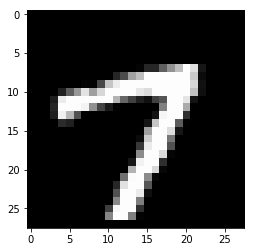

In [18]:
with tf.Session() as sess:
    saver.restore(sess, save_path)
    
    index = random.randint(0, len(mnist.train.images))
    image = mnist.train.images[index]
    label = mnist.train.labels[index]
    
    logit = sess.run(logits, feed_dict={
        features: [image],
        labels: [label]
    })[0]
    
    # This is just to make the print statement nicer
    label = label.astype(int)
    logit = logit.astype(int)

    print('\nLabel: {}\nArgmax: {}\n\nLogit: {}\nArgmax: {}'.format(label, np.argmax(label), logit, np.argmax(logit)))
    
    show_image(image)